Please fill out the information of your group!

| <p style="text-align: center;">First Name</p>  | <p style="text-align: center;">Family Name</p> | Matr.-No. |
| ---------------------------------------------- | ---------------------------------------------- | -------- |
| <p style="text-align: left">Elias</p>| <p style="text-align: left">Mindelberger</p> | k12043382 |
| <p style="text-align: left">Pascal</p>| <p style="text-align: left">Pilz</p> | k12111234 |



<h2 style="text-align: center">344.105/6/7 UE: Natural Language Processing (WS2023/24)</h2>
<h1 style="color:rgb(0,120,170)">Assignment 2</h1>
<h2 style="color:rgb(0,120,170)">Getting to Know Word Embedding!</h2>

<b>Terms of Use</b><br>
This  material is prepared for educational purposes at the Johannes Kepler University (JKU) Linz, and is exclusively provided to the registered students of the mentioned course at JKU. It is strictly forbidden to distribute the current file, the contents of the assignment, and its solution. The use or reproduction of this manuscript is only allowed for educational purposes in non-profit organizations, while in this case, the explicit prior acceptance of the author(s) is required.

**Authors:** Navid Rekab-saz, Oleg Lesota<br>


<h2>Table of contents</h2>
<ol>
    <a href="#section-general-guidelines"><li style="font-size:large;font-weight:bold">General Guidelines</li></a>
    <a href="#section-taskA"><li style="font-size:large;font-weight:bold">Task A: Words Similarity and Nearest Neighbors (15 points)</li></a>
    <a href="#section-taskB"><li style="font-size:large;font-weight:bold">Task B: Document Classification with Word Embedding (15 points)</li></a>
    <a href="#section-taskC"><li style="font-size:large;font-weight:bold">Task C: Classification with sent2vec Document Embeddings (2 extra point)</li></a>
    <a href="#section-references"><li style="font-size:large;font-weight:bold">References</li></a>
    
</ol>

<a name="section-general-guidelines"></a><h2 style="color:rgb(0,120,170)">General Guidelines</h2>

### Assignment objective
The aim of this assignment is to get familiarized with using word embedding (WE) models in practice. The assignment in total has **30 points**; it also offers **2 extra points** which can cover any missing point.

This Notebook encompasses all aspects of the assignment, namely the descriptions of tasks as well as your solutions and reports. Feel free to add any required cell for solutions. The cells can contain code, reports, charts, tables, or any other material, required for the assignment. Feel free to provide the solutions in an interactive and visual way! 

Please discuss any unclear point in the assignment in the provided forum in MOODLE. It is also encouraged to provide answers to your peer's questions. However when submitting a post, keep in mind to avoid providing solutions. Please let the tutor(s) know shall you find any error or unclarity in the assignment.


### Libraries & Dataset

The assignment should be implemented with recent versions of `Python` (>3.7). Any standard Python library can be used, so far that the library is free and can be simply installed using `pip` or `conda`. Examples of potentially useful libraries are `scikit-learn`, `numpy`, `scipy`, `gensim`, `nltk`, `spaCy`, and `AllenNLP`. Use the latest stable version of each library.

To conduct the experiments, we use a subset of the `HumSet` dataset [1] (https://blog.thedeep.io/humset/). `HumSet` is created by the DEEP (https://www.thedeep.io) project – an open source platform which aims to facilitate processing of textual data for international humanitarian response organizations. The platform enables the classification of text excerpts, extracted from news and reports into a set of domain specific classes. The provided dataset contains the classes (labels) referring to the humanitarian sectors like agriculture, health, and protection. The dataset contains an overall number of 17,301 data points. 

Download the dataset from the Moodle page of the course.

the provided zip file consists of the following files:
- `thedeep.subset.train.txt`: Train set in csv format with three fields: sentence_id, text, and label.
- `thedeep.subset.validation.txt`: Validation set in csv format with three fields: sentence_id, text, and label.
- `thedeep.subset.test.txt`: Test set in csv format with three fields: sentence_id, text, and label.
- `thedeep.subset.label.txt`: Captions of the labels.
- `thedeep.ToU.txt`: Terms of use of the dataset.

[1] HumSet: Dataset of Multilingual Information Extraction and Classification for Humanitarian Crises Response
*Selim Fekih, Nicolo' Tamagnone, Benjamin Minixhofer, Ranjan Shrestha, Ximena Contla, Ewan Oglethorpe and Navid Rekabsaz.* 
In Findings of the 2022 Conference on Empirical Methods in Natural Language Processing (Findings of EMNLP), December 2022.



### Submission

Each group should submit the following two files:

- One Jupyter Notebook file (`.ipynb`), containing all the code, results, visualizations, etc. **In the submitted Notebook, all the results and visualizations should already be present, and can be observed simply by loading the Notebook in a browser.** The Notebook must be self-contained, meaning that (if necessary) one can run all the cells from top to bottom without any error. Do not forget to put in your names and student numbers in the first cell of the Notebook. 
- The HTML file (`.html`) achieved from exporting the Jupyter Notebook to HTML (Download As HTML).

You do not need to include the data files in the submission.


## Imports, globabl variables, data loading

In [1]:
import sklearn as skl
import numpy as np
import scipy as sc
import gensim
import nltk
import spacy
# import allennlp

import re
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
DATA_PATH = r"../nlp2023_24_data/"

TRAIN_PATH = DATA_PATH + "thedeep.subset.train.txt"
VAL_PATH = DATA_PATH + "thedeep.subset.validation.txt"
TEST_PATH = DATA_PATH + "thedeep.subset.test.txt"

LABEL_LEGEND_PATH = DATA_PATH + "thedeep.labels.txt"

COL_NAMES = ["_id", "data", "label"]

UNKNOWN = "<UNK>"

In [3]:
RAW_TRAIN = pd.read_csv(TRAIN_PATH, header=None)
RAW_VAL = pd.read_csv(VAL_PATH, header=None)
RAW_TEST = pd.read_csv(TEST_PATH, header=None)

RAW_TRAIN.columns = RAW_VAL.columns = RAW_TEST.columns = COL_NAMES

print(f"{RAW_TRAIN.shape=}, {RAW_VAL.shape=}, {RAW_TEST.shape=}")

RAW_TRAIN.head()

RAW_TRAIN.shape=(12110, 3), RAW_VAL.shape=(2596, 3), RAW_TEST.shape=(2595, 3)


,_id,data,label
0,5446,In addition to the immediate life-saving inter...,9
1,8812,There are approximately 2.6 million people cla...,3
2,16709,"While aid imports have held up recently, comme...",5
3,3526,Heavy rainfalls as well as onrush of water fro...,0
4,4928,"Based on field reports 9 , the main production...",3


In [4]:
id2name = {}

with open(LABEL_LEGEND_PATH, "r") as f:
    for line in f:
        num_name = line.strip().split(',')
        num, name = num_name
        id2name[int(num)] = name

<a name="section-taskA"></a><h2 style="color:rgb(0,120,170)">Task A: Words Similarity and Nearest Neighbors (15 points)</h2>


**Loading a word embedding (WE) model (1 points).** Download a pre-trained word embedding model such as word2vec (https://code.google.com/archive/p/word2vec/) or GloVe (https://nlp.stanford.edu/projects/glove/). You can load the downloaded vectors into arrays, or use libraries such as `gensim` to download and process the vectors. 

**Calculating word-to-word similarities (4 points).** Select <ins>5 arbitrary words</ins> from 5 different topics like objects, science disciplines, verbs, adjectives, animals, etc. Let us refer to these words as *source words*. For each source word, calculate its cosine similarities to <ins>6 target words</ins>. The target words of each source word are also selected by you and should cover various levels of semantic relations – according to your linguistic judgement – to the source word, namely from highly-related to not related at all. Organize the target words in tables, such that the target words of each source word are sorted from the highest to the lowest relevance (according to your judgement). Consider the following points:

- **Implementation (2/4 points):** Implement cosine similarity as a function that takes two vectors and returns the similarity score. Implement cosine by yourself and do NOT use the provided functionalities of any library.
- **Reporting and observations (2/4 points):** Report the calculated similarities side by side with your word-to-word semantic relevance judgements in tables. Compare the results and report your observations.  

**Calculating nearest neighbors (10 points).** For the 5 source words, retrieve the $k=10$ nearest neighbors using the word embedding model, namely the words with the highest similarities to the source word. Consider the following points: 
    
- **Overall implementation (3/10 points):** your implemented function takes a source vector, a set of target vectors, and the $k$ parameter, and returns the $k$ nearest neighbors and their similarity scores. Implement nearest neighbor calculation by yourself and do NOT use the provided functionalities of any library.
- **Similarity metrics (2/10 points):** execute the calculation of nearest neighbors according to <ins>two similarity metrics</ins> namely cosine and dot product.
- **Efficiency (3/10 points):** your nearest neighbor functions should provide an *efficient* calculation of nearest neighbors. An inefficient way (which should be avoided!) would be looping over the set of vectors in the word embedding model, and one by one calculating the cosine/dot product similarity of the source vector to each of the target vectors. As a hint for an efficient way, consider that in `numpy` (and other libraries), calculating the dot product of a vector to a matrix is much faster than the dot products of the vector to each vector of the matrix.
- **Reporting and observations (2/10 points):** report the results in tables, which enable comparing between the outputs of the two similarity metrics. Which similarity metric would you prefer? Report your observations.

</div>

## Loading word embedding model

In [5]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin.gz', binary=True)

# getting the embeddings matrix

vocab = list(model.key_to_index.keys())
embedding_matrix = np.array([model[word] for word in vocab])
print(embedding_matrix.shape)

(3000000, 300)


## Calculating word-to-word similarities

### Implementation of cosine similarity

In [6]:
def convert_inputs(x, Y):
    """
    Helper functions to convert inputs to numpy arrays and transpose them if necessary.
    """
    x = np.asarray(x)
    Y = np.asarray(Y)
    if Y.shape[0] != len(x):
        Y = Y.T
    return x, Y

In [7]:
def cos_sim(x: np.ndarray, Y: np.ndarray):
    """
    Computes the cosine similarity between a source vector x and multiple target vectors Y.
    """
    x, Y = convert_inputs(x, Y)
    return (x @ Y) / (np.linalg.norm(x) * np.linalg.norm(Y, axis=0))

### Reporting and observations

**In the following, the target words are arranged in descending order by our personal understanding of semanting closeness.**

In [8]:
from tabulate import tabulate

words = [{"source": "green",      "target": ["blue", "red", "ultraviolet", "plant", "sky", "dog"]},
         {"source": "running",    "target": ["jogging", "walking", "driving", "sport", "sleeping", "potato"]},
         {"source": "girlfriend", "target": ["wife", "sister", "brother", "friend", "acquaintances", "horse"]},
         {"source": "window",     "target": ["door", "entrance", "opening", "wall", "house", "sky"]},
         {"source": "helping",    "target": ["aiding", "assisting", "assistance", "supporting", "support", "skis"]}]

for elem in words:
    source = elem["source"]
    elem["cos_sim"] = cos_sim(model[source], [model[word] for word in elem["target"]])
    df = pd.DataFrame(elem)
    df = df.sort_values(by="cos_sim", ascending=False)
    table = tabulate(df, tablefmt="fancy_grid")
    print(table)
    print()

╒═══╤═══════╤═════════════╤══════════╕
│ 1 │ green │ red         │ 0.536024 │
├───┼───────┼─────────────┼──────────┤
│ 0 │ green │ blue        │ 0.492465 │
├───┼───────┼─────────────┼──────────┤
│ 2 │ green │ ultraviolet │ 0.211983 │
├───┼───────┼─────────────┼──────────┤
│ 4 │ green │ sky         │ 0.211147 │
├───┼───────┼─────────────┼──────────┤
│ 3 │ green │ plant       │ 0.175136 │
├───┼───────┼─────────────┼──────────┤
│ 5 │ green │ dog         │ 0.105045 │
╘═══╧═══════╧═════════════╧══════════╛

╒═══╤═════════╤══════════╤═══════════╕
│ 1 │ running │ walking  │ 0.389901  │
├───┼─────────┼──────────┼───────────┤
│ 0 │ running │ jogging  │ 0.349886  │
├───┼─────────┼──────────┼───────────┤
│ 2 │ running │ driving  │ 0.285482  │
├───┼─────────┼──────────┼───────────┤
│ 4 │ running │ sleeping │ 0.210244  │
├───┼─────────┼──────────┼───────────┤
│ 3 │ running │ sport    │ 0.107662  │
├───┼─────────┼──────────┼───────────┤
│ 5 │ running │ potato   │ 0.0302481 │
╘═══╧═════════╧═════════

**It appears to me that the model does not always have the same understanding as we do. For example, I personally would say that 'green' and 'plant' are closer than 'green' and 'sky'. My guess is that this is due to the model being trained on news report, which might be biased.**

## Calculating nearest neighbors

**It turns out that when we use all 3,000,000 embeddings we get some weird matches, like 'wearin_o', 'workers_differently_Corenthal', and 'QEII_TJ_Marta' for 'green'. For this reason, we also do a version where only use the top 10,000 words, i.e., the 10,000 most frequent words.**

### Implementation

In [9]:
def find_x(x, Y):
    """
    Helper functions that finds a 1d array x from a 2d array Y, if present.
    """
    x, Y = convert_inputs(x, Y)
    Y = Y.T
    row_indices = np.where((Y == x).all(axis=1, keepdims=True))[0]
    return row_indices

def knn(x, Y, k=10, sim_metric=cos_sim):
    """
    Returns the indices and similarity values of the k closest values of Y to x.
    """
    sims = sim_metric(x, Y)
    idx = find_x(x, Y) # finding the index of the word in order to exlude it
    sims[idx] = -np.inf # excluding the word itself
    indices = np.argpartition(sims, -k)[-k:] # getting the top k word
    indices = indices[np.argsort(sims[indices])][::-1] # sorting the indices in descending order
    return indices, sims[indices]

### kNN based on cosine similarity

#### Using all embeddings

In [10]:
results_cos = []
for elem in tqdm(words):
    word = elem["source"]
    indices, similarities = knn(model[word], embedding_matrix)
    results_cos.append({"source": word, "indices": indices, "similarities": similarities})

for elem in results_cos:
    temp = {"src": elem["source"],
            "res": [model.index_to_key[idx] for idx in elem["indices"]],
            "sim": elem["similarities"]}
    df = pd.DataFrame(temp)
    table = tabulate(df, tablefmt="fancy_grid")
    print(table)
    print()

100%|██████████| 5/5 [00:18<00:00,  3.70s/it]

╒═══╤═══════╤═══════════════════════════════╤══════════╕
│ 0 │ green │ wearin_o                      │ 0.575597 │
├───┼───────┼───────────────────────────────┼──────────┤
│ 1 │ green │ greener                       │ 0.549947 │
├───┼───────┼───────────────────────────────┼──────────┤
│ 2 │ green │ workers_differently_Corenthal │ 0.542416 │
├───┼───────┼───────────────────────────────┼──────────┤
│ 3 │ green │ QEII_TJ_Marta                 │ 0.540607 │
├───┼───────┼───────────────────────────────┼──────────┤
│ 4 │ green │ red                           │ 0.536024 │
├───┼───────┼───────────────────────────────┼──────────┤
│ 5 │ green │ Leyritz_Ford_Expedition       │ 0.528963 │
├───┼───────┼───────────────────────────────┼──────────┤
│ 6 │ green │ greening                      │ 0.5262   │
├───┼───────┼───────────────────────────────┼──────────┤
│ 7 │ green │ Pentwater_Civic               │ 0.523985 │
├───┼───────┼───────────────────────────────┼──────────┤
│ 8 │ green │ Kimmie_Mi_Hyun_Ki

#### Using the top 10,000 embeddings

In [11]:
results_cos = []
for elem in tqdm(words):
    word = elem["source"]
    indices, similarities = knn(model[word], embedding_matrix[:10_000, :])
    results_cos.append({"source": word, "indices": indices, "similarities": similarities})

for elem in results_cos:
    temp = {"src": elem["source"],
            "res": [model.index_to_key[idx] for idx in elem["indices"]],
            "sim": elem["similarities"]}
    df = pd.DataFrame(temp)
    table = tabulate(df, tablefmt="fancy_grid")
    print(table)
    print()

100%|██████████| 5/5 [00:00<00:00, 167.51it/s]

╒═══╤═══════╤══════════════════╤══════════╕
│ 0 │ green │ red              │ 0.536024 │
├───┼───────┼──────────────────┼──────────┤
│ 1 │ green │ yellow           │ 0.493958 │
├───┼───────┼──────────────────┼──────────┤
│ 2 │ green │ blue             │ 0.492465 │
├───┼───────┼──────────────────┼──────────┤
│ 3 │ green │ Green            │ 0.488492 │
├───┼───────┼──────────────────┼──────────┤
│ 4 │ green │ brown            │ 0.459749 │
├───┼───────┼──────────────────┼──────────┤
│ 5 │ green │ orange           │ 0.442939 │
├───┼───────┼──────────────────┼──────────┤
│ 6 │ green │ pink             │ 0.426737 │
├───┼───────┼──────────────────┼──────────┤
│ 7 │ green │ sustainability   │ 0.414324 │
├───┼───────┼──────────────────┼──────────┤
│ 8 │ green │ renewable_energy │ 0.402405 │
├───┼───────┼──────────────────┼──────────┤
│ 9 │ green │ gray             │ 0.399266 │
╘═══╧═══════╧══════════════════╧══════════╛

╒═══╤═════════╤═══════════╤══════════╕
│ 0 │ running │ Running   │ 0.697858

### kNN based on dot product

In [12]:
def dot(x, Y):
    """
    Calculates the dot product between a vector x and a matrix Y. This is its own function for input handling purposes.
    """
    x, Y = convert_inputs(x, Y)
    return x @ Y

#### Using all embeddings

In [13]:
results_dot = []
for elem in tqdm(words):
    word = elem["source"]
    indices, similarities = knn(model[word], embedding_matrix, sim_metric=dot)
    results_dot.append({"source": word, "indices": indices, "similarities": similarities})

for elem in results_dot:
    temp = {"src": elem["source"],
            "res": [model.index_to_key[idx] for idx in elem["indices"]],
            "sim": elem["similarities"]}
    df = pd.DataFrame(temp)
    table = tabulate(df, tablefmt="fancy_grid")
    print(table)
    print()

100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

╒═══╤═══════╤═══════════════════════════╤═════════╕
│ 0 │ green │ AZ_az_,0_9                │ 6.77562 │
├───┼───────┼───────────────────────────┼─────────┤
│ 1 │ green │ pot_bunker                │ 6.17658 │
├───┼───────┼───────────────────────────┼─────────┤
│ 2 │ green │ Newspapers_below          │ 5.85016 │
├───┼───────┼───────────────────────────┼─────────┤
│ 3 │ green │ Environmental_Design_LEED │ 5.80033 │
├───┼───────┼───────────────────────────┼─────────┤
│ 4 │ green │ validate_breakout         │ 5.55656 │
├───┼───────┼───────────────────────────┼─────────┤
│ 5 │ green │ Trend_Appearin_Aug.       │ 5.51186 │
├───┼───────┼───────────────────────────┼─────────┤
│ 6 │ green │ fairway_bunker            │ 5.24974 │
├───┼───────┼───────────────────────────┼─────────┤
│ 7 │ green │ greener                   │ 5.24185 │
├───┼───────┼───────────────────────────┼─────────┤
│ 8 │ green │ birdie_putt               │ 5.1139  │
├───┼───────┼───────────────────────────┼─────────┤
│ 9 │ green 

#### Using the top 10,000 embeddings

In [14]:
results_dot = []
for elem in tqdm(words):
    word = elem["source"]
    indices, similarities = knn(model[word], embedding_matrix[:10_000, :], sim_metric=dot)
    results_dot.append({"source": word, "indices": indices, "similarities": similarities})

for elem in results_dot:
    temp = {"src": elem["source"],
            "res": [model.index_to_key[idx] for idx in elem["indices"]],
            "sim": elem["similarities"]}
    df = pd.DataFrame(temp)
    table = tabulate(df, tablefmt="fancy_grid")
    print(table)
    print()

100%|██████████| 5/5 [00:00<00:00, 401.12it/s]

╒═══╤═══════╤══════════════════╤═════════╕
│ 0 │ green │ greens           │ 4.27324 │
├───┼───────┼──────────────────┼─────────┤
│ 1 │ green │ birdie           │ 4.13303 │
├───┼───────┼──────────────────┼─────────┤
│ 2 │ green │ tee              │ 3.96393 │
├───┼───────┼──────────────────┼─────────┤
│ 3 │ green │ renewable_energy │ 3.83775 │
├───┼───────┼──────────────────┼─────────┤
│ 4 │ green │ yellow           │ 3.70807 │
├───┼───────┼──────────────────┼─────────┤
│ 5 │ green │ carbon           │ 3.5913  │
├───┼───────┼──────────────────┼─────────┤
│ 6 │ green │ red              │ 3.58333 │
├───┼───────┼──────────────────┼─────────┤
│ 7 │ green │ sustainability   │ 3.55586 │
├───┼───────┼──────────────────┼─────────┤
│ 8 │ green │ bogey            │ 3.44972 │
├───┼───────┼──────────────────┼─────────┤
│ 9 │ green │ orange           │ 3.39396 │
╘═══╧═══════╧══════════════════╧═════════╛

╒═══╤═════════╤════════════════╤═════════╕
│ 0 │ running │ Running        │ 4.84042 │
├───┼─────

### Comparing cosine and dot product

In [15]:
for cos_elem, dot_elem in zip(results_cos, results_dot):
    temp = {"cos": [model.index_to_key[idx] for idx in cos_elem["indices"]],
            "dot": [model.index_to_key[idx] for idx in dot_elem["indices"]]}
    df = pd.DataFrame(temp)
    headers = ['Cosine', 'Dot Product']
    table = tabulate(df, tablefmt="fancy_grid", headers=headers)
    print(cos_elem["source"])
    print(table)
    print()

green
╒════╤══════════════════╤══════════════════╕
│    │ Cosine           │ Dot Product      │
╞════╪══════════════════╪══════════════════╡
│  0 │ red              │ greens           │
├────┼──────────────────┼──────────────────┤
│  1 │ yellow           │ birdie           │
├────┼──────────────────┼──────────────────┤
│  2 │ blue             │ tee              │
├────┼──────────────────┼──────────────────┤
│  3 │ Green            │ renewable_energy │
├────┼──────────────────┼──────────────────┤
│  4 │ brown            │ yellow           │
├────┼──────────────────┼──────────────────┤
│  5 │ orange           │ carbon           │
├────┼──────────────────┼──────────────────┤
│  6 │ pink             │ red              │
├────┼──────────────────┼──────────────────┤
│  7 │ sustainability   │ sustainability   │
├────┼──────────────────┼──────────────────┤
│  8 │ renewable_energy │ bogey            │
├────┼──────────────────┼──────────────────┤
│  9 │ gray             │ orange           │
╘═══

**We chose to show the results for the top 10,000 embeddings, as these are less obscure.**

**In my opinion, the cosine similarity produces better results.**

<a name="section-taskB"></a><h2 style="color:rgb(0,120,170)">Task B: Document Classification with WE (15 points)</h2>


This task follows the same instruction for document classification as provided in Assignment 1. You are indeed free to reuse any part of your code in Assignment 1 for this task. In Assignment 1, the representation of each document was created using a bag of words representation followed by dimensionality reduction. In this task, the document representations are created from the pre-trained word embeddings.

**Map word embeddings to dictionary words (5 points).** For every word in the dictionary (as discussed and created in Assignment 1), fetch the corresponding word embedding from the pre-trained model. If no embedding is found, initialize the corresponding word embedding randomly.

**Document embedding as the average of word embeddings (5 points).** Using the word embeddings, the representation of each document is defined as the *mean of the vectors of each document's words*. In particular, given the document $d$, consisting of words $\left[ v_1, v_2, ..., v_{|d|} \right]$, the document representation $\mathbf{e}_d$ is defined as:

$\mathbf{e}_d = \frac{1}{|d|}\sum_{i=1}^{|d|}{\mathbf{e}_{v_i}}$

where $\mathbf{e}_{v}$ is the vector of the word $v$, and $|d|$ is the length of the document.

**Classification and evaluation (5 points)** Using these new document representations, apply <ins>three classification algorithms</ins> and report the evaluation results (based on accuracy metric) on the test set.



In [16]:
model.most_similar("Austria")

[('Germany', 0.7461062073707581),
 ('Austrian', 0.7455943822860718),
 ('Switzerland', 0.7306346297264099),
 ('Hungary', 0.6867430210113525),
 ('Slovakia', 0.6693456768989563),
 ('Austrians', 0.668468713760376),
 ('Croatia', 0.646854043006897),
 ('Innsbruck', 0.6342576146125793),
 ('Defending_champion_Markus_Brier', 0.6316500306129456),
 ('Czech_Republic', 0.6239066123962402)]

In [17]:
def clean_string(val):
    if isinstance(val, str):
        val = val.lower()
        val = re.sub(r"\W", " ", val)
        val = re.sub(r"\s{2,}", " ", val)
        return val
    else:
        return val

train = RAW_TRAIN.map(clean_string)
val = RAW_VAL.map(clean_string)
test = RAW_TEST.map(clean_string)

train = train.map(lambda x: x.split() if isinstance(x, str) else x)
val = val.map(lambda x: x.split() if isinstance(x, str) else x)
test = test.map(lambda x: x.split() if isinstance(x, str) else x)

In [18]:
train["data"].shape

(12110,)

In [19]:
def get_embedding(word):  # get embedding of single words
    try:
        return model[word]
    except KeyError:
        default_rng = np.random.default_rng(42)
        return default_rng.standard_normal(300)

In [20]:
def get_sentence_embedding(sentence):  # get embedding of sentences via averaging
    return np.mean(np.array([get_embedding(word) for word in sentence]), axis=0)

In [21]:
def get_sentence_embeddings(sentences):  # get embedding of multiple sentences
    return np.array([get_sentence_embedding(sentence) for sentence in sentences])

In [22]:
train_embeddings = get_sentence_embeddings(train["data"])
val_embeddings = get_sentence_embeddings(val["data"])
test_embeddings = get_sentence_embeddings(test["data"])

In [23]:
print(f"{train_embeddings.shape=}, {val_embeddings.shape=}, {test_embeddings.shape=}")  # inpect shapes

train_embeddings.shape=(12110, 300), val_embeddings.shape=(2596, 300), test_embeddings.shape=(2595, 300)


Shapes seem correct!

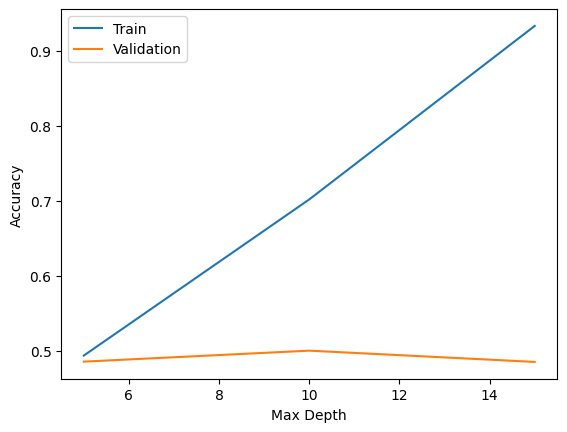

In [28]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [5, 10, 15]
models = []

for param in param_grid:
    dt = DecisionTreeClassifier(random_state=42, max_depth=param)
    dt.fit(train_embeddings, train["label"])
    models.append(dt)

from sklearn.metrics import accuracy_score

train_accs = []
val_accs = []

for model in models:
    train_accs.append(accuracy_score(model.predict(train_embeddings), train["label"]))
    val_accs.append(accuracy_score(model.predict(val_embeddings), val["label"]))

plt.plot(param_grid, train_accs, label="Train")
plt.plot(param_grid, val_accs, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


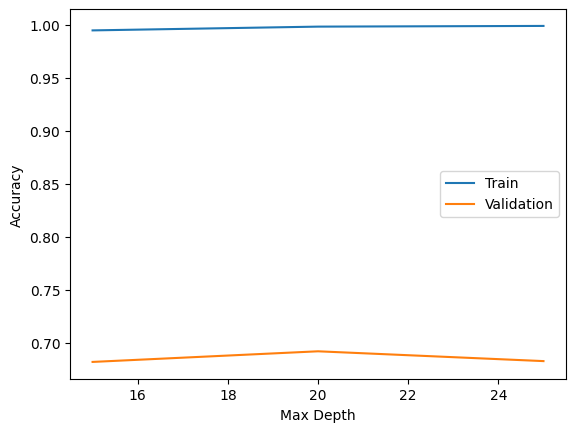

In [30]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = [15, 20, 25]
models_rf = []

for param in param_grid_rf:
    rfc = RandomForestClassifier(random_state=42, max_depth=param)
    rfc.fit(train_embeddings, train["label"])
    models_rf.append(rfc)

train_accs_rf = []
val_accs_rf = []

for model in models_rf:
    train_accs_rf.append(accuracy_score(model.predict(train_embeddings), train["label"]))
    val_accs_rf.append(accuracy_score(model.predict(val_embeddings), val["label"]))

plt.plot(param_grid_rf, train_accs_rf, label="Train")
plt.plot(param_grid_rf, val_accs_rf, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

/home/th3lias/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/th3lias/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/th3lias/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/th3lias/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/th3lias/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` i

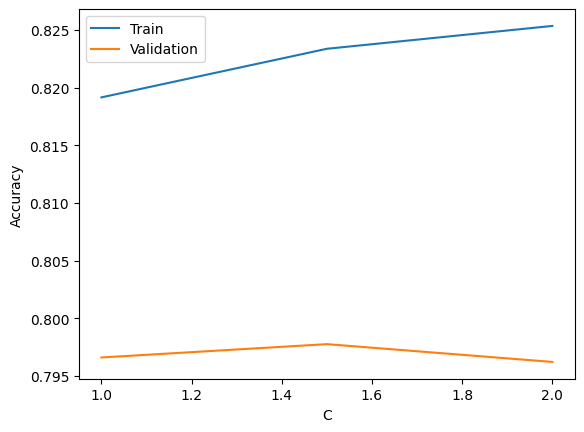

In [34]:
from sklearn.svm import LinearSVC

param_grid_svm = [1., 1.5, 2]
models_svm = []

for param in param_grid_svm:
    svm = LinearSVC(random_state=42, C=param)
    svm.fit(train_embeddings, train["label"])
    models_svm.append(svm)

train_accs_svm = []
val_accs_svm = []

for model in models_svm:
    train_accs_svm.append(accuracy_score(model.predict(train_embeddings), train["label"]))
    val_accs_svm.append(accuracy_score(model.predict(val_embeddings), val["label"]))

plt.plot(param_grid_svm, train_accs_svm, label="Train")
plt.plot(param_grid_svm, val_accs_svm, label="Validation")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

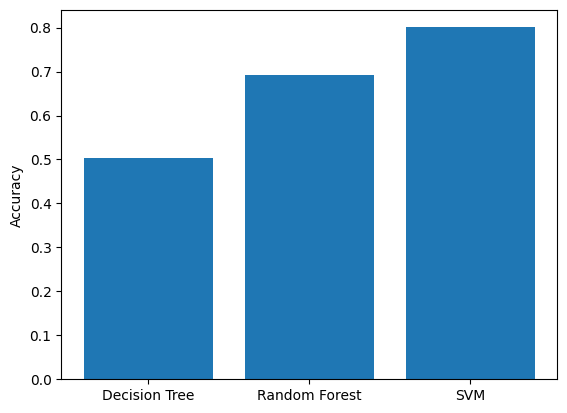

In [40]:
from sklearn.metrics import accuracy_score

methods = ["Decision Tree", "Random Forest", "SVM"]

accs_dt = [accuracy_score(model.predict(test_embeddings), test["label"]) for model in models]  # plot best accuracy of each method
accs_rf = [accuracy_score(model.predict(test_embeddings), test["label"]) for model in models_rf]
accs_svm = [accuracy_score(model.predict(test_embeddings), test["label"]) for model in models_svm]

best_accs = [max(accs_dt), max(accs_rf), max(accs_svm)]

plt.bar(methods, best_accs)  # plot the methods on the test set in simple bar chart
plt.ylabel("Accuracy")
plt.show()

As we can see, the linear SVM outperforms the random forest and the decision tree with an accuracy of about 0.8. The random forest yields an accuracy of about 0.7 and the decision tree an accuracy of about 0.5.

<a name="section-taskC"></a><h2 style="color:rgb(0,120,170)">Task C: Classification with sent2vec Document Embeddings (2 extra point)</h2>


Sent2vec [1] suggests another unsupervised approach to creating document embeddings from the underlying word embeddings. First, using the provided code in the paper, train a sendtvec model on the training set to create document embeddings. Then, repeat Task B while using the document embeddings provided by sent2vec. Similar to Task 2, conduct the classification experiments and report evaluation results.

[1] M. Pagliardini, P. Gupta, and M. Jaggi. Unsupervised Learning of Sentence Embeddings using Compositional n-Gram Features. In Proceedings of the conference of the North American Chapter of the Association for Computational Linguistics (NAACL), 2018.
